1. Ride Demand Prediction (Regression or Time-Series Forecasting)

Loading Modules : 

In [39]:
import pandas as pd
import glob             # For getting a list of files in a directory
import numpy as np

# For Visualization
import matplotlib.pyplot as plt
import seaborn as sns

Loading Dataset : 

In [2]:
# CSV - 2014
files_2014 = glob.glob("../Dataset/Topic_1n2/*14.csv")
# to concatenate all the files
df_2014 = pd.concat([pd.read_csv(f, encoding="latin1") for f in files_2014]) # used latin1 encoding as utf-8 didn't work which is by default

# CSV - 2015
files_2015 = pd.read_csv("../Dataset/Topic_1n2/uber-raw-data-janjune-15.csv", encoding="latin1")
df_2015 = pd.DataFrame(files_2015)

In [3]:
df_2014.head(5)

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [4]:
df_2015.head(5)

,Dispatching_base_num,Pickup_date,Affiliated_base_num,locationID
0,B02617,2015-05-17 09:47:00,B02617,141
1,B02617,2015-05-17 09:47:00,B02617,65
2,B02617,2015-05-17 09:47:00,B02617,100
3,B02617,2015-05-17 09:47:00,B02774,80
4,B02617,2015-05-17 09:47:00,B02617,90


In [5]:
# As 2014 data gives exact lat/lon coordinates, Will predict using 2014 data
df_2014.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4534327 entries, 0 to 1028135
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Date/Time  object 
 1   Lat        float64
 2   Lon        float64
 3   Base       object 
dtypes: float64(2), object(2)
memory usage: 173.0+ MB


Data pre-processing

In [6]:
df_2014.isnull().sum()

Date/Time    0
Lat          0
Lon          0
Base         0
dtype: int64

In [7]:
print(df_2014.duplicated().sum())

82581


In [8]:
df_2014.drop_duplicates()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512
...,...,...,...,...
1028131,9/30/2014 22:57:00,40.7668,-73.9845,B02764
1028132,9/30/2014 22:57:00,40.6911,-74.1773,B02764
1028133,9/30/2014 22:58:00,40.8519,-73.9319,B02764
1028134,9/30/2014 22:58:00,40.7081,-74.0066,B02764


Feature Engineering

In [9]:
# Converting the 'Date/Time' column to datetime format
df_2014['Date/Time'] = pd.to_datetime(df_2014['Date/Time'], format = '%m/%d/%Y %H:%M:%S')
# df_2015['Pickup_date'] = pd.to_datetime(df_2015['Pickup_date'], format = '%Y-%m-%d %H:%M:%S')

In [10]:
# As per the data, we can split time into 3 parts: Hour, Minute
# Convert Date into : Weekday

# Not considering month (as limited months)
df_2014['WeekDay'] = df_2014['Date/Time'].dt.weekday
df_2014['Hour'] = df_2014['Date/Time'].dt.hour
# Creating 15-mins bin as without it considering minutes creates noise. 
df_2014['Minute_bin'] = df_2014['Date/Time'].dt.floor('15min')

# df_2015['Day'] = df_2015['Pickup_date'].dt.weekday
# df_2015['Month'] = df_2015['Pickup_date'].dt.month
# df_2015['Hour'] = df_2015['Pickup_date'].dt.hour
# df_2015['Minute'] = df_2015['Pickup_date'].dt.minute

In [11]:
# Rounding the latitude and longitude to 2 decimal places, as can't predict exact precised location
df_2014['Lat'] = df_2014['Lat'].round(2)
df_2014['Lon'] = df_2014['Lon'].round(2)

In [12]:
df_2014.drop(columns = ['Date/Time'], inplace = True)

In [13]:
df_2014.head(5)

,Lat,Lon,Base,WeekDay,Hour,Minute_bin
0,40.77,-73.95,B02512,1,0,2014-04-01 00:00:00
1,40.73,-74.03,B02512,1,0,2014-04-01 00:15:00
2,40.73,-73.99,B02512,1,0,2014-04-01 00:15:00
3,40.76,-73.98,B02512,1,0,2014-04-01 00:15:00
4,40.76,-73.97,B02512,1,0,2014-04-01 00:30:00


EDA :

1. Day of the week vs No. of trips

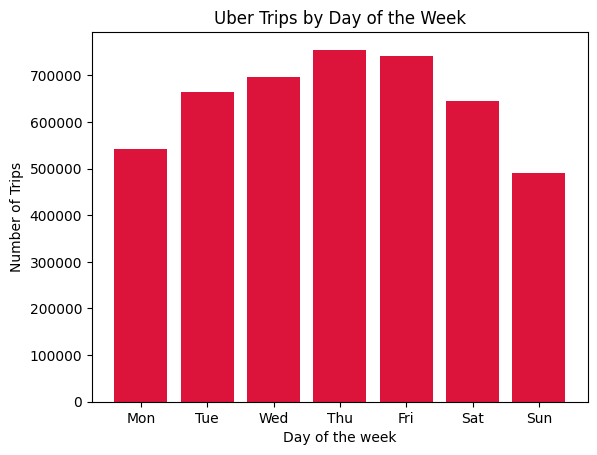

In [14]:
# Bar plot :
plt.title('Uber Trips by Day of the Week')
plt.xlabel('Day of the week')
plt.ylabel('Number of Trips') 
x = df_2014['WeekDay'].value_counts().sort_index()
plt.bar(x.index, x.values, color = 'crimson')
plt.xticks(ticks = x.index, labels= ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

* Trips are maximum on Thursdays & Fridays.
* Trips are minimum on Sundays & it is logically considerable as people may like to take a rest on that day.

Conclusion : 
* Uber ride demand is highest on Thursdays and Fridays, with approximately 755,145 and 741,139 trips respectively. 
* In contrast, Sundays and Mondays see significantly lower demand, with around 490,180 and 541,472 trips. 
* This pattern suggests that Uber should allocate more drivers and resources towards the end of the week to meet higher demand, while reducing fleet capacity on Sundays and Mondays to optimize operational efficiency.

2. No. of trips per hour (BAR PLOT)

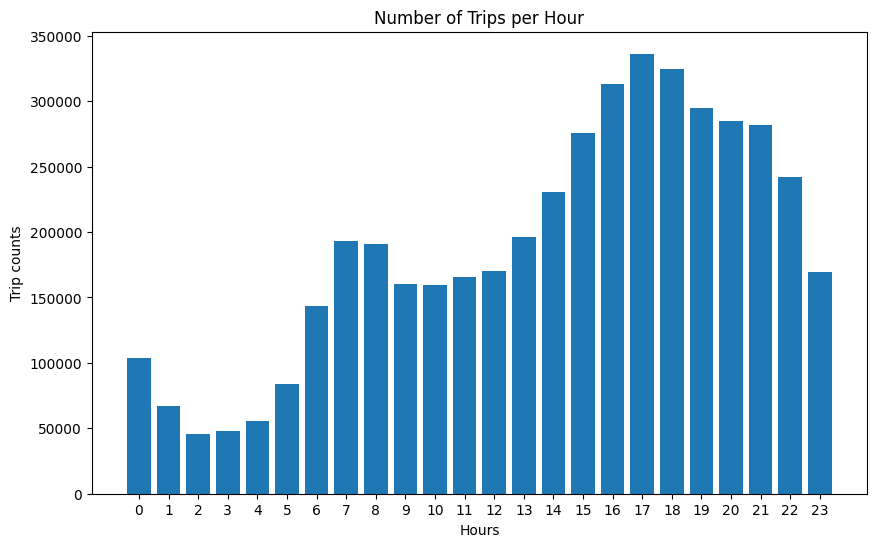

In [24]:
plt.figure(figsize=(10,6))
plt.title('Number of Trips per Hour')
plt.xlabel('Hours')
plt.ylabel('Trip counts')
y = df_2014['Hour'].value_counts().sort_index()
plt.bar(y.index, y.values)
plt.xticks(ticks=range(24))
plt.show()

Hence, we can conclude from thsi graph that :
- There's a sudden peak in trip demand 6-7AM & around 5PM.
- Peak demand window is 4PM - 7PM.

3. Trips by WeekDay & Hour

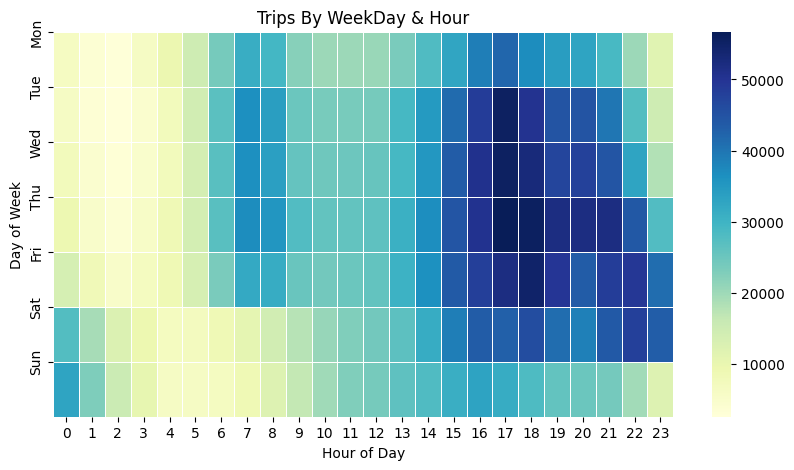

In [45]:
plt.figure(figsize=(10, 5))
plt.title('Trips By WeekDay & Hour')
sns.heatmap(df_2014.groupby(['WeekDay', 'Hour']).size().unstack(), cmap='YlGnBu', linewidth=0.5)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.yticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=90)
plt.show()

In [ ]:
# Grouping for trip_count
grouped = df_2014.groupby(['Hour', 'Minute_bin', 'Lat', 'Lon']).size().reset_index(name='Trip_Count')